# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

***

## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os

## General Helper Methods

In [2]:
def to_grayscale(image, read_method='mpimg'):
    '''Return grayscale version of image. Give read_method for color order for proper conversion'''
    if read_method == 'cv2':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif read_method == 'mpimg':
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        print("WARNING: read_method {} is not valid. Assuming cv2.".format(read_method))
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
def get_images(image_folder_path, get_file_names=False):
    '''Gets a list of images from the given directory'''
    images = []
    file_names = os.listdir(image_folder_path)
    file_names.sort()
    for file_name in file_names:
        if file_name.split('.')[-1] == 'jpg':
            images.append(mpimg.imread('{}/{}'.format(image_folder_path, file_name)))
                              
    if get_file_names:
        return images, file_names

    return images

def display_images(images, names, cmap=None):
    '''Display images in subplot format'''
    assert(len(images) == len(names))

    fig, axs = plt.subplots(int((len(images)+1)/2), 2, figsize=(10, len(images) * 1.5))
    fig.tight_layout()

    for i in range(len(images)):
        image = images[i]
        image_name = names[i]
        axs[int(i/2)][i%2].imshow(image, cmap=cmap) 
        axs[int(i/2)][i%2].set_title('{}'.format(image_name))

## Camera Calibration

### Helper Methods

In [3]:
def find_chessboard_corners(gray, n_inside_corners_x, n_inside_corners_y):
    ret, corners = cv2.findChessboardCorners(gray, (n_inside_corners_x, n_inside_corners_y))
    if not ret:
        print("WARNING: Could not find corners")
    return corners

def get_corners_image(image, corners, n_inside_corners_x, n_inside_corners_y):
    copied_image = image.copy()
    return cv2.drawChessboardCorners(copied_image, (n_inside_corners_x, n_inside_corners_y), corners, True)

def get_obj_points(n_inside_corners_x, n_inside_corners_y):
    obj_points = np.zeros((n_inside_corners_x*n_inside_corners_y, 3), np.float32)
    obj_points[:,:2] = np.mgrid[0:n_inside_corners_x,0:n_inside_corners_y].T.reshape(-1,2)
    return obj_points

def get_camera_matrix_and_distortion(image, object_points, image_points):
    gray = to_grayscale(image)
    _, mtx, dist, _, _ = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)
    return mtx, dist

def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist)

### Main Code

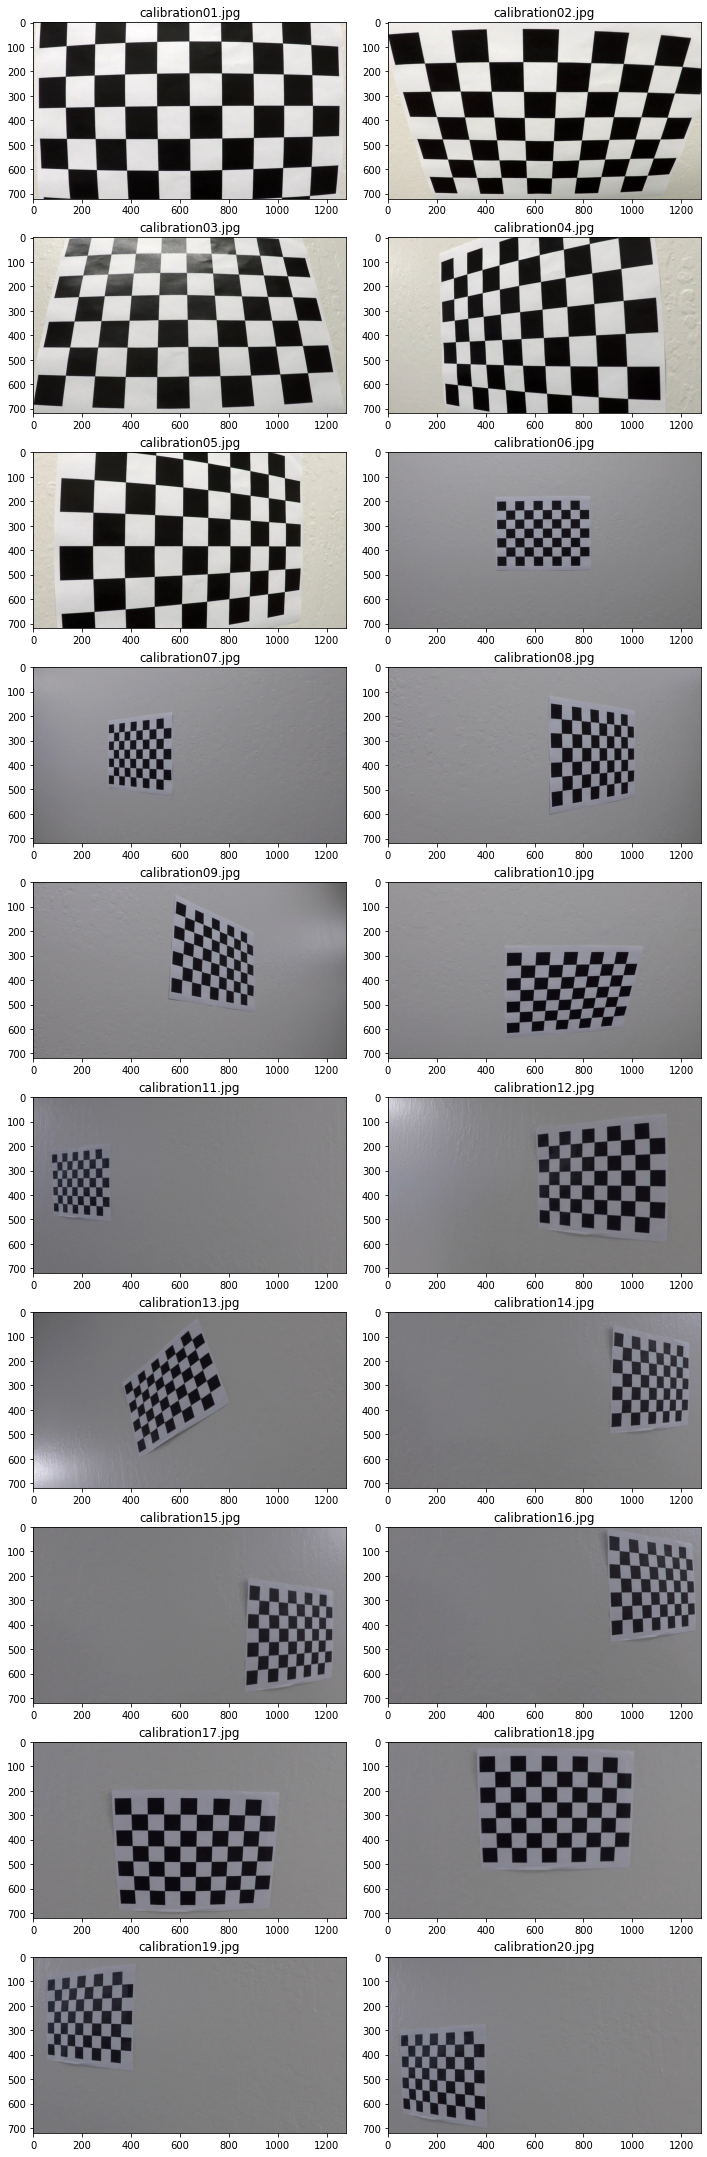

In [4]:
# Read in calibration images and display them
calibration_images, calibration_image_file_names = get_images('./camera_cal', get_file_names=True)
display_images(calibration_images, calibration_image_file_names)

In [5]:
# Find corners in chessboard and display them
n_inside_corners_x = 9
n_inside_corners_y = 6

# Output message
print("Finding corners in calibration images. Assuming n_inside_corners_x = {}. n_inside_corners_y = {}".format(n_inside_corners_x, n_inside_corners_y))
print()

all_obj_points = []
all_img_points = []

corners_images = []
invalid_image_indices = []
for i, calibration_image in enumerate(calibration_images):
    # Find corners
    obj_points = get_obj_points(n_inside_corners_x, n_inside_corners_y)
    corners = find_chessboard_corners(to_grayscale(calibration_image), n_inside_corners_x, n_inside_corners_y)
    
    # Skip images in which corners could not be found    
    if corners is None or obj_points.shape[0] != corners.shape[0]:
        print("Invalid image found at index {}. Skipping.".format(i))
        invalid_image_indices.append(i)
        continue
    
    # Create corners image
    corners_images.append(get_corners_image(calibration_image, corners, n_inside_corners_x, n_inside_corners_y))

    # Store points
    all_obj_points.append(obj_points)
    all_img_points.append(corners)
    
# Output message
print()
print("Corners successfully found in {}/{} images.".format(len(corners_images), len(calibration_images)))

Finding corners in calibration images. Assuming n_inside_corners_x = 9. n_inside_corners_y = 6

Invalid image found at index 0. Skipping.
Invalid image found at index 3. Skipping.
Invalid image found at index 4. Skipping.

Corners successfully found in 17/20 images.


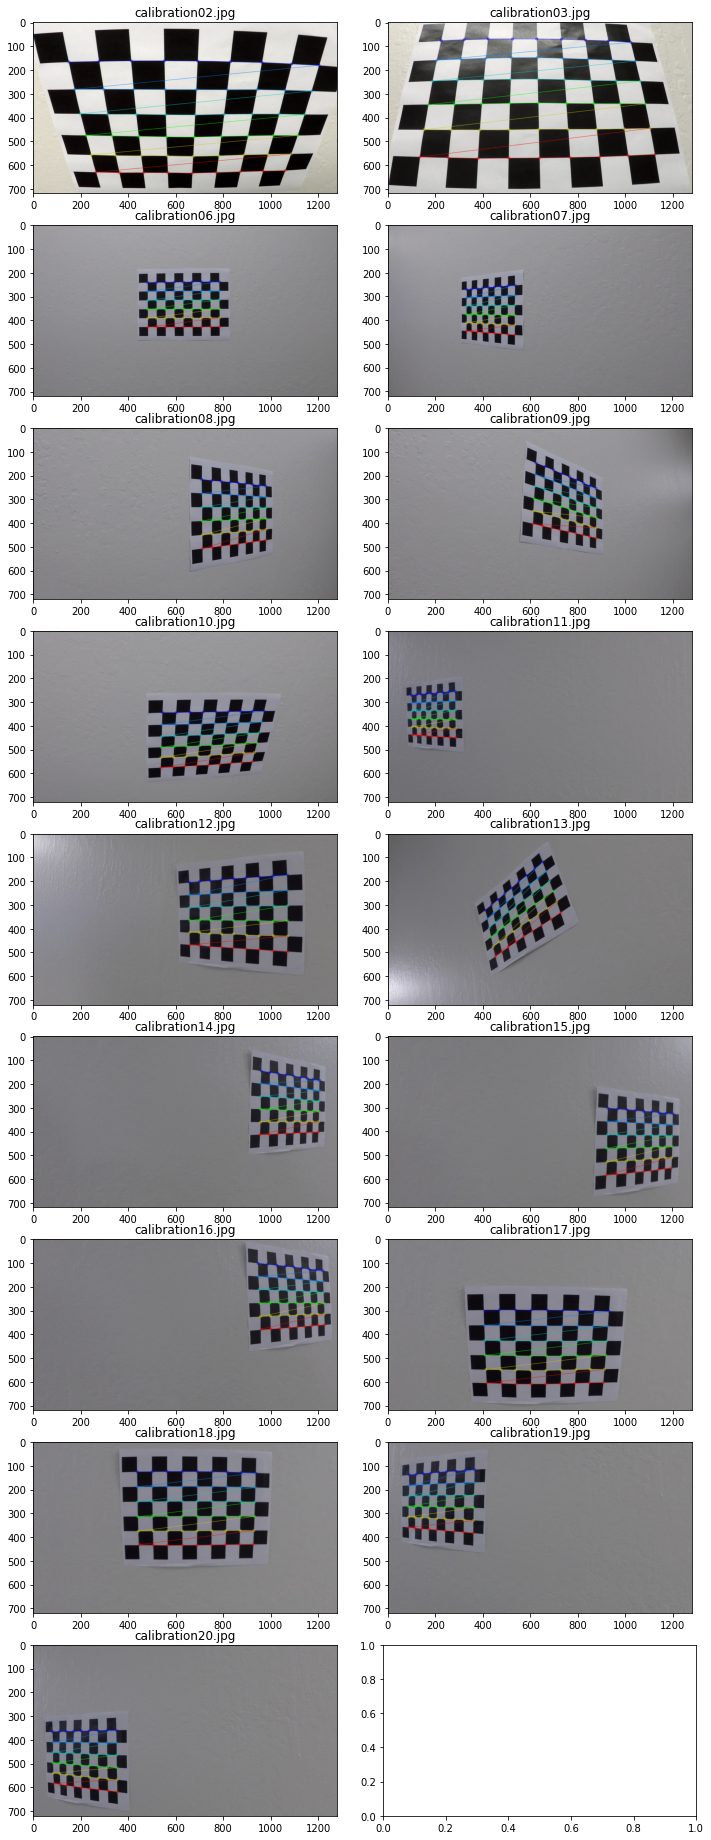

In [6]:
# Display corner images
corners_names = calibration_image_file_names.copy()
for invalid_image_index in reversed(invalid_image_indices):
    corners_names.pop(invalid_image_index)
    
display_images(corners_images, corners_names)

In [7]:
# Calculate camera matrix and distortion
camera_matrix, distortion_matrix = get_camera_matrix_and_distortion(calibration_images[0], all_obj_points, all_img_points)
print("camera_matrix = \n{}".format(camera_matrix))
print()
print("distortion_matrix = \n{}".format(distortion_matrix))

camera_matrix = 
[[1.15777829e+03 0.00000000e+00 6.67113868e+02]
 [0.00000000e+00 1.15282230e+03 3.86124656e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

distortion_matrix = 
[[-0.24688571 -0.02372833 -0.00109832  0.00035104 -0.00260415]]


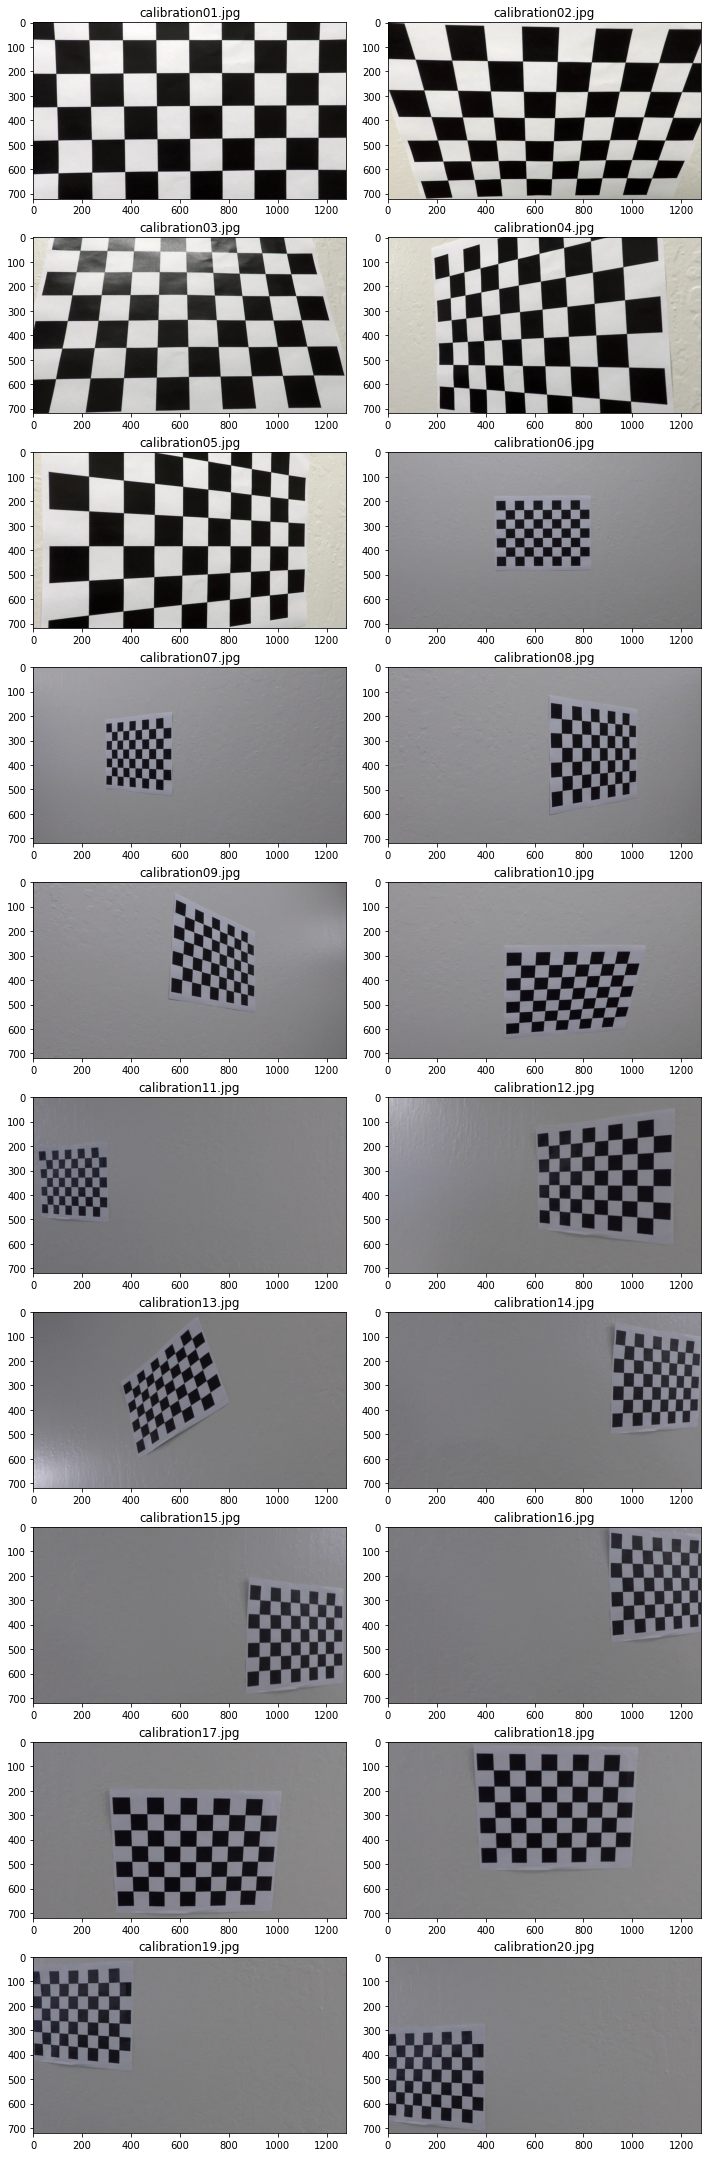

In [8]:
# Display undistorted images
undistorted_calibration_images = [undistort(img, camera_matrix, distortion_matrix) for img in calibration_images]
display_images(undistorted_calibration_images, calibration_image_file_names)

## Perspective Transform

In [9]:
def perspective_transform(image, corners, camera_matrix, distortion_matrix):
    src = np.float32([corners[0],
                      corners[1],
                      corners[2],
                      corners[3]])
    
    border_size = 1 / 8
    height, width, channels = image.shape
    dest = np.float32([[border_size*width, border_size*height],
                       [(1-border_size)*width, border_size*height],
                       [border_size*width, (1-border_size)*height],
                       [(1-border_size)*width, (1-border_size)*height]])
    M = cv2.getPerspectiveTransform(src, dest)
    perspective_image = cv2.warpPerspective(image, M, (width, height))
    
    return perspective_image, M

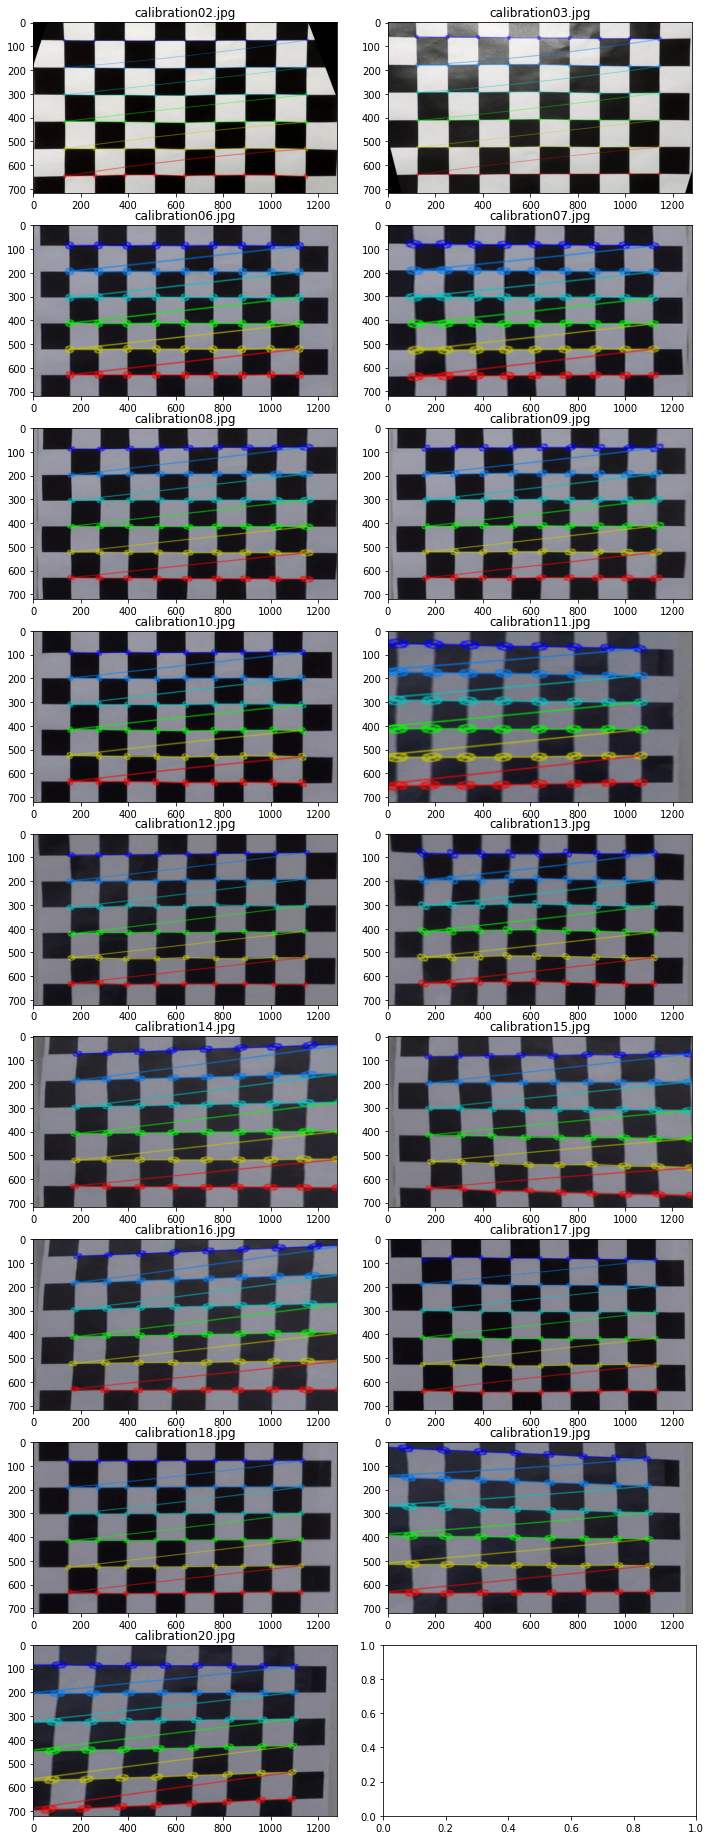

In [10]:
# Display perspective images
perspective_names = corners_names.copy()
perspective_images = corners_images.copy()

four_corners_list = [[corners[0],
                      corners[n_inside_corners_x-1],
                      corners[n_inside_corners_x*(n_inside_corners_y-1)],
                      corners[n_inside_corners_x*n_inside_corners_y-1]]
                     for corners in all_img_points]
perspective_images = [undistort(img, camera_matrix, distortion_matrix) for img in perspective_images]
perspective_images = [perspective_transform(perspective_images[i], four_corners_list[i], camera_matrix, distortion_matrix)[0] for i in range(len(perspective_images))]
display_images(perspective_images, perspective_names)

## Read in Images

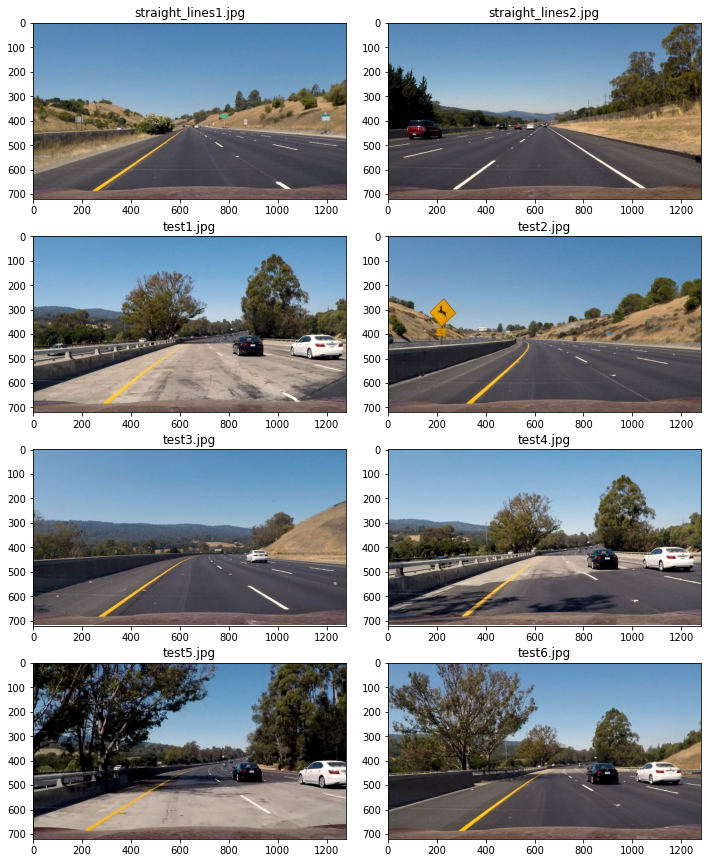

In [11]:
# Read in lane line images and display them
lane_line_images, lane_line_image_file_names = get_images('./test_images', get_file_names=True)
display_images(lane_line_images, lane_line_image_file_names)

## Thresholded Binary Image

In [25]:
def abs_sobel_thresh(image, orient=[1,0], thresh=(0, 255)):
    '''x is [1, 0]. y is [0, 1]'''
    # 1) Convert to grayscale
    grayscaleImage = to_grayscale(image)
    
    # 2) Take derivative in given orientation
    sobel = cv2.Sobel(grayscaleImage, cv2.CV_64F, orient[0], orient[1])
    
    # 3) Take absolute value of gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # 5) Create mask of 1's where the magnitude is within thresholds
    thresh_min, thresh_max = thresh
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel < thresh_max)] = 1
    
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    grayscaleImage = to_grayscale(image)
    
    # 2) Take gradients in x and y
    sobelx = cv2.Sobel(grayscaleImage, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(grayscaleImage, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    sobelxy = (sobelx**2 + sobely**2)**0.5
    
    # 4) Scale to 8 bit int
    scaled_sobelxy = np.uint8(255 * sobelxy / np.max(sobelxy))
    
    # 5) Create binary mask where mag thresholds are met
    thresh_min, thresh_max = mag_thresh
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy > thresh_min) & (scaled_sobelxy < thresh_max)] = 1
    
    return binary_output

def dir_thresh(image, sobel_kernel=3, thresh_degrees=(0, 90)):
    # 1) Convert to grayscale
    grayscaleImage = to_grayscale(image)
    
    # 2) Take gradient in x and y
    sobelx = cv2.Sobel(grayscaleImage, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(grayscaleImage, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take absoluate value of gradient
    sobelxy = (sobelx**2 + sobely**2)**0.5
    
    # 4) Calculate direction
    direction_degrees = np.rad2deg(np.arctan2(np.abs(sobely), np.abs(sobelx)))

    # 5) Create binary mask when thresholds are met
    thresh_min, thresh_max = thresh_degrees
    binary_output = np.zeros_like(sobelxy)
    binary_output[(direction_degrees > thresh_min) & (direction_degrees < thresh_max)] = 1
    
    return binary_output

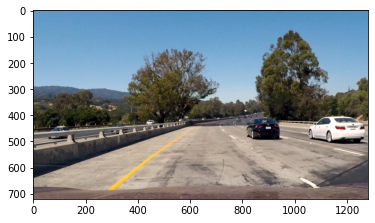

In [53]:
# Create binary images
example_image = lane_line_images[2]
plt.imshow(example_image)
gradx = abs_sobel_thresh(example_image, orient=[1, 0], thresh=[20, 100])
grady = abs_sobel_thresh(example_image, orient=[0, 1], thresh=[20, 100])
gradxy = abs_sobel_thresh(example_image, orient=[1, 1], thresh=[5, 100])
gradxy_2 = abs_sobel_thresh(example_image, orient=[1, 1], thresh=[10, 100])
mag_binary = mag_thresh(example_image, sobel_kernel=9, mag_thresh=[30, 100])
dir_binary = dir_thresh(example_image, sobel_kernel=15, thresh_degrees=[30, 80])

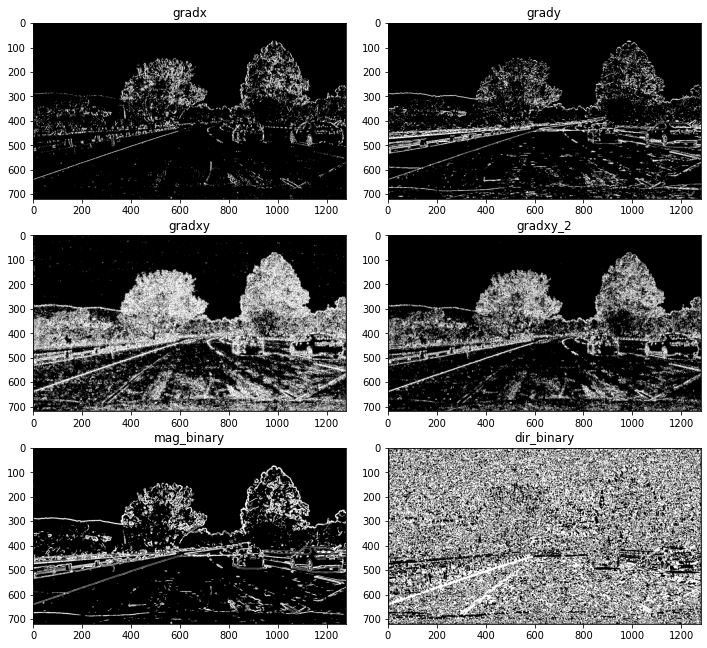

In [54]:
# Display binary images
display_images([gradx, grady, gradxy, gradxy_2, mag_binary, dir_binary], ['gradx', 'grady', 'gradxy', 'gradxy_2', 'mag_binary', 'dir_binary'], cmap='gray')

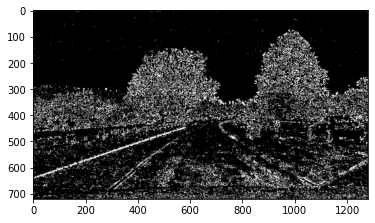

In [51]:
# Display combined binary images
combined = np.zeros_like(dir_binary)
combined[(gradxy == 1) & (dir_binary == 1)] = 1
plt.imshow(combined, cmap='gray')

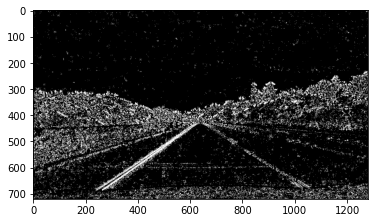

In [48]:
# Display combined binary images
combined = np.zeros_like(dir_binary)
combined[(gradxy == 1) & (dir_binary == 1)] = 1
plt.imshow(combined, cmap='gray')

## Process Image

In [15]:
def process_image(image):

SyntaxError: unexpected EOF while parsing (<ipython-input-15-b6242a85cd9b>, line 1)